Found 55 CSV files
CO group: 35 files
FL group: 20 files

CO files: ['CO001.csv', 'CO001_converted.csv', 'CO002.csv', 'CO003.csv', 'CO004.csv', 'CO005.csv', 'CO006.csv', 'CO007.csv', 'CO008.csv', 'CO009.csv', 'CO010.csv', 'CO011.csv', 'CO012.csv', 'CO013.csv', 'CO014.csv', 'CO015.csv', 'CO016.csv', 'CO017.csv', 'CO019.csv', 'CO020.csv', 'CO021.csv', 'CO022.csv', 'CO023.csv', 'CO024.csv', 'CO027.csv', 'CO028.csv', 'CO030.csv', 'CO031.csv', 'CO032.csv', 'CO035.csv', 'CO037.csv', 'CO039.csv', 'CO040.csv', 'CO041.csv', 'CO042.csv']

FL files: ['FL004.csv', 'FL005.csv', 'FL006.csv', 'FL007.csv', 'FL008.csv', 'FL009.csv', 'FL011.csv', 'FL014.csv', 'FL016.csv', 'FL018.csv', 'FL019.csv', 'FL021.csv', 'FL022.csv', 'FL023.csv', 'FL025.csv', 'FL027.csv', 'FL031.csv', 'FL033.csv', 'FL035.csv', 'FL036.csv']


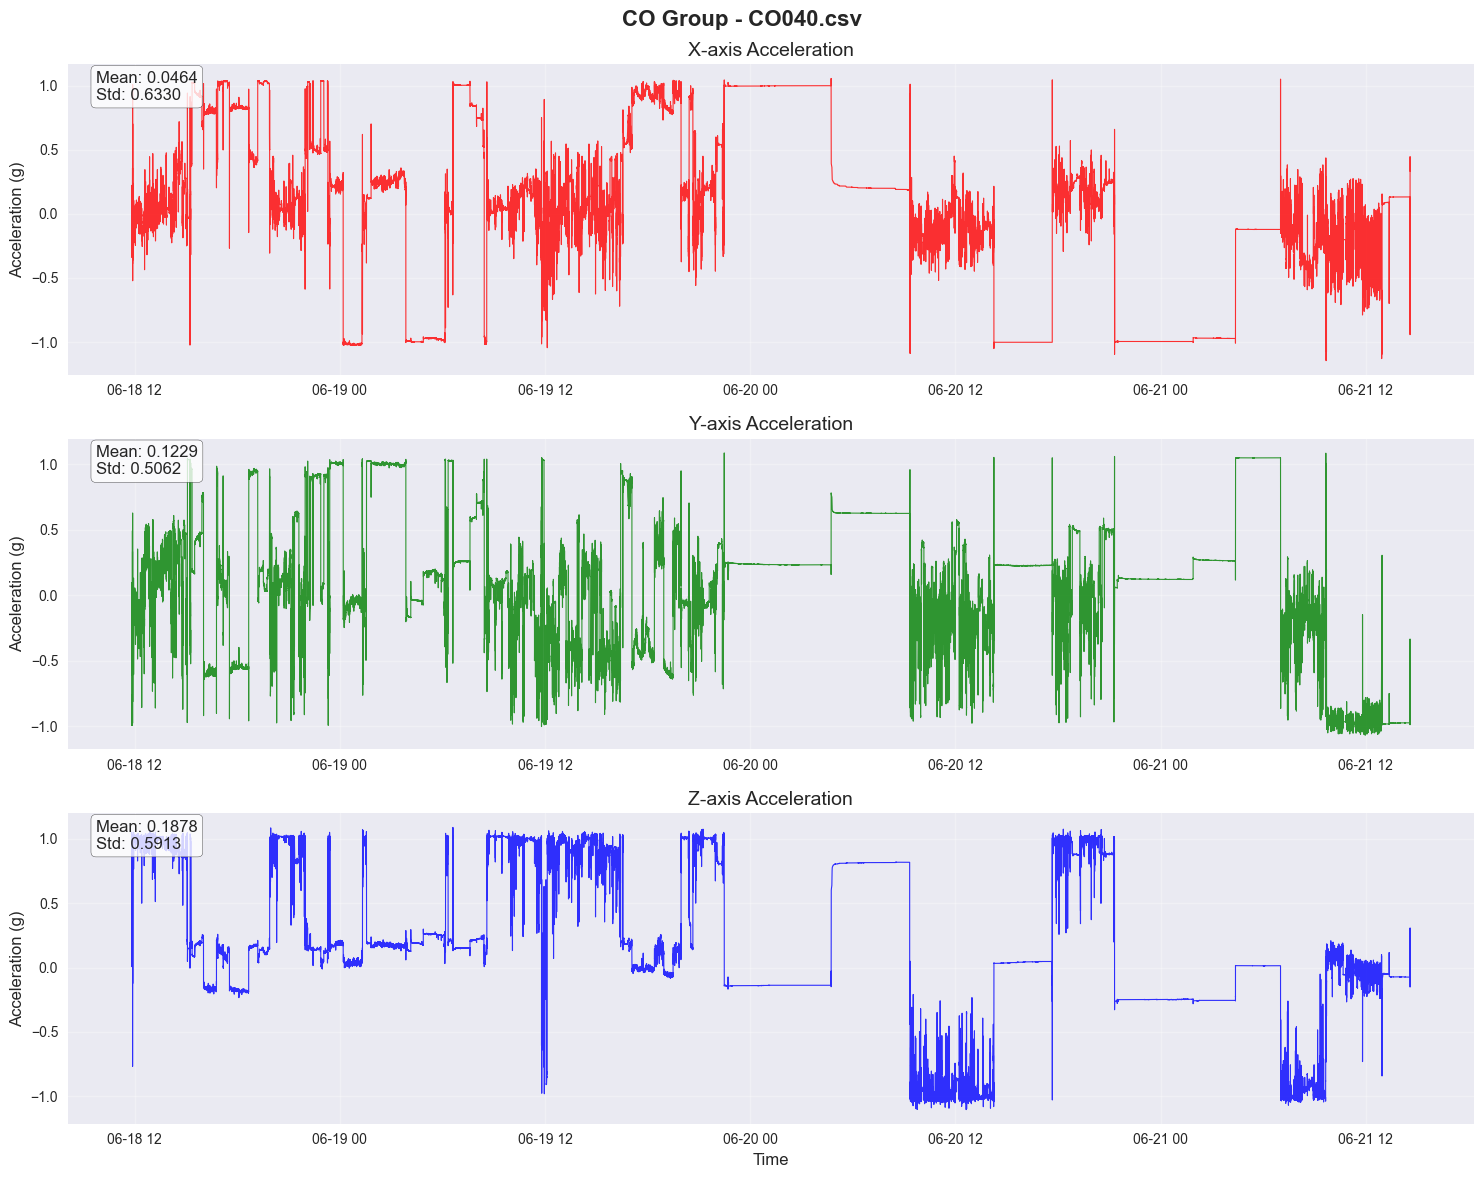


Summary statistics for CO040.csv:
                   x              y              z
count  269138.000000  269138.000000  269138.000000
mean        0.046368       0.122935       0.187816
std         0.632951       0.506185       0.591333
min        -1.145221      -1.066085      -1.102365
25%        -0.195877      -0.156022      -0.140561
50%         0.084922       0.167869       0.094966
75%         0.388657       0.387486       0.817375
max         1.055550       1.086003       1.087182

Duration: 3 days 02:45:37
Number of samples: 269138
Sampling rate: 1.00 Hz
--------------------------------------------------------------------------------


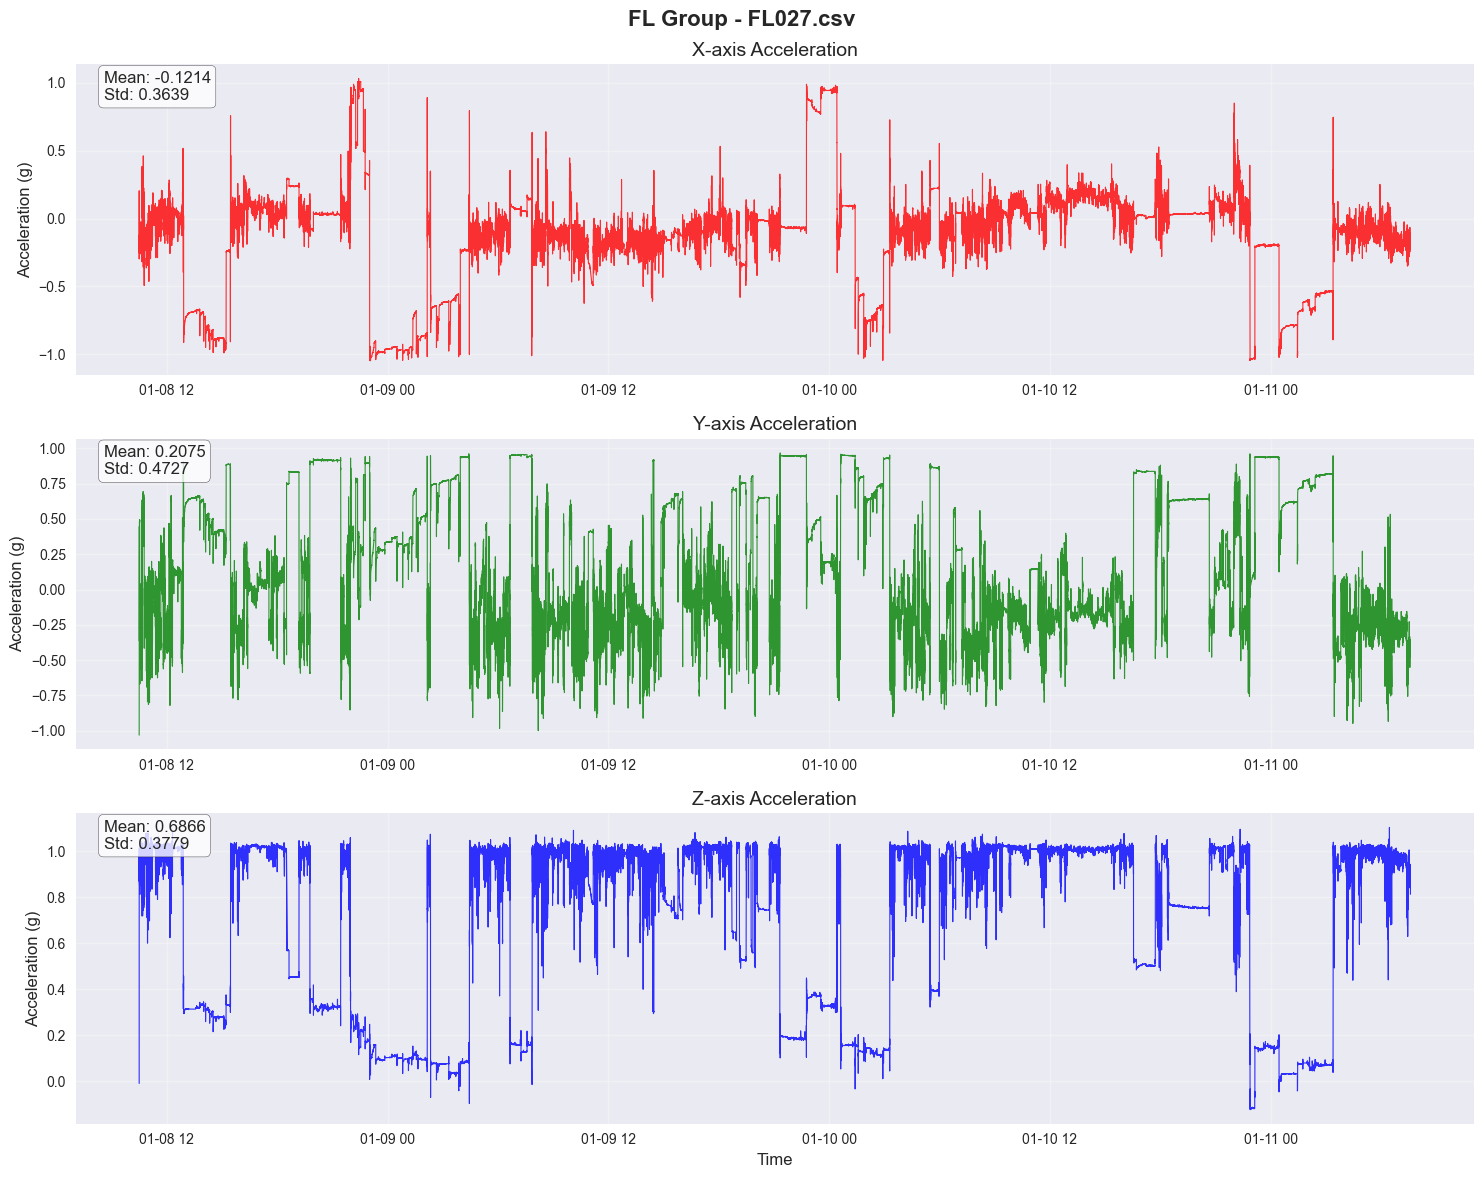


Summary statistics for FL027.csv:
                   x              y              z
count  248759.000000  248759.000000  248759.000000
mean       -0.121386       0.207454       0.686560
std         0.363886       0.472731       0.377940
min        -1.047204      -1.031546      -0.123616
25%        -0.197192      -0.211572       0.310531
50%        -0.064434       0.112325       0.935016
75%         0.042871       0.645025       1.005333
max         1.031918       0.967697       1.103829

Duration: 2 days 21:05:58
Number of samples: 248759
Sampling rate: 1.00 Hz
--------------------------------------------------------------------------------


In [9]:
# This cell explores the LTMM dataset by reading and plotting all time series data,
# similar to the main() function in ltmm_analysis.py, but interactively.
# Now, it also marks non-wear periods as red bands using wear_times.csv.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Define the data directory path (update as needed)
data_dir = "/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/CL_Support/physionet.org/files/ltmm/second_level"

# Path to wear_times.csv (update as needed)
wear_times_path = "wear_times.csv"

# Get all CSV files
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
print(f"Found {len(csv_files)} CSV files")

# Separate files by group (CO vs FL)
co_files = [f for f in csv_files if f.startswith('CO')]
fl_files = [f for f in csv_files if f.startswith('FL')]

print(f"CO group: {len(co_files)} files")
print(f"FL group: {len(fl_files)} files")
print(f"\nCO files: {sorted(co_files)}")
print(f"\nFL files: {sorted(fl_files)}")

def read_csv_file(file_path):
    """Read a CSV file and return a pandas DataFrame with proper timestamp parsing"""
    try:
        df = pd.read_csv(file_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def get_nonwear_periods(wear_df, pig_id, data_start, data_end):
    """
    Given the wear_times DataFrame, pig_id, and the data's time range,
    return a list of (start, end) tuples for non-wear periods.
    """
    nonwear_periods = []
    pig_rows = wear_df[wear_df['pig_id'] == pig_id]
    for _, row in pig_rows.iterrows():
        # For each row, non-wear periods are between take_off_X and put_on_X
        # and before start_time and after end_time if present
        # Columns: start_time, take_off_1, put_on_1, take_off_2, put_on_2, end_time
        # All times are strings or NaN
        times = {}
        for col in ['start_time', 'take_off_1', 'put_on_1', 'take_off_2', 'put_on_2', 'end_time']:
            val = row.get(col, None)
            if pd.notna(val) and str(val).strip() != '':
                try:
                    times[col] = pd.to_datetime(val)
                except Exception:
                    times[col] = None
            else:
                times[col] = None

        # Non-wear before start_time (if start_time exists)
        if times['start_time'] is not None:
            # If the data starts before start_time, mark as non-wear
            if data_start < times['start_time']:
                nonwear_periods.append((data_start, times['start_time']))

        # Non-wear between take_off_1 and put_on_1
        if times['take_off_1'] is not None and times['put_on_1'] is not None:
            if times['take_off_1'] < times['put_on_1']:
                nonwear_periods.append((times['take_off_1'], times['put_on_1']))

        # Non-wear between take_off_2 and put_on_2
        if times['take_off_2'] is not None and times['put_on_2'] is not None:
            if times['take_off_2'] < times['put_on_2']:
                nonwear_periods.append((times['take_off_2'], times['put_on_2']))

        # Non-wear after end_time (if end_time exists)
        if times['end_time'] is not None:
            if times['end_time'] < data_end:
                nonwear_periods.append((times['end_time'], data_end))
    return nonwear_periods

def plot_time_series(df, filename, group_name, nonwear_periods=None):
    """Plot the x, y, z time series for a single file, with non-wear periods as red bands"""
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'{group_name} - {filename}', fontsize=16, fontweight='bold')
    colors = ['red', 'green', 'blue']
    axes_labels = ['X-axis', 'Y-axis', 'Z-axis']
    for i, (col, color, label) in enumerate(zip(['x', 'y', 'z'], colors, axes_labels)):
        axes[i].plot(df.index, df[col], color=color, linewidth=0.8, alpha=0.8)
        axes[i].set_title(f'{label} Acceleration', fontsize=14)
        axes[i].set_ylabel('Acceleration (g)', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        mean_val = df[col].mean()
        std_val = df[col].std()
        axes[i].text(0.02, 0.98, f'Mean: {mean_val:.4f}\nStd: {std_val:.4f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        # Add non-wear periods as red bands
        if nonwear_periods is not None:
            for start, end in nonwear_periods:
                # Only plot if band_start < band_end
                if start is not None and end is not None and start < end:
                    axes[i].axvspan(start, end, color='red', alpha=0.3, zorder=0)
    axes[-1].set_xlabel('Time', fontsize=12)
    plt.tight_layout()
    plt.show()
    print(f"\nSummary statistics for {filename}:")
    print(df.describe())
    print(f"\nDuration: {df.index[-1] - df.index[0]}")
    print(f"Number of samples: {len(df)}")
    print(f"Sampling rate: {len(df) / (df.index[-1] - df.index[0]).total_seconds():.2f} Hz")
    print("-" * 80)

# Read wear_times.csv
wear_times = pd.read_csv(wear_times_path)

# Example: Read and plot the first CO file (if available)
if co_files:
    example_file = co_files[0]
    file_path = os.path.join(data_dir, example_file)
    df = read_csv_file(file_path)
    if df is not None:
        # Extract pig_id from filename (e.g., CO-001.csv -> CO-001)
        pig_id = example_file.split('.')[0]
        # Get non-wear periods for this pig, using the data's time range
        data_start = df.index.min()
        data_end = df.index.max()
        nonwear_periods = get_nonwear_periods(wear_times, pig_id, data_start, data_end)
        plot_time_series(df, example_file, 'CO Group', nonwear_periods=nonwear_periods)

# Example: Read and plot the first FL file (if available)
if fl_files:
    example_file = fl_files[0]
    file_path = os.path.join(data_dir, example_file)
    df = read_csv_file(file_path)
    if df is not None:
        pig_id = example_file.split('.')[0]
        data_start = df.index.min()
        data_end = df.index.max()
        nonwear_periods = get_nonwear_periods(wear_times, pig_id, data_start, data_end)
        plot_time_series(df, example_file, 'FL Group', nonwear_periods=nonwear_periods)


In [ ]:
import pandas as pd
import os
import re
from datetime import datetime

# Read wear_times.csv
wear_times = pd.read_csv('wear_times.csv')

def get_nonwear_periods(pig_id, day, wear_row):
    """
    Given a row from wear_times, return a list of (start, end) tuples for non-wear periods.
    All times are returned as pandas.Timestamp.
    """
    take_off_cols = [col for col in wear_row.index if col.startswith('take_off')]
    put_on_cols = [col for col in wear_row.index if col.startswith('put_on')]
    take_off_cols = sorted(take_off_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)
    put_on_cols = sorted(put_on_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)

    def parse_time(val):
        if pd.isna(val) or str(val).strip() == '':
            return None
        return pd.to_datetime(val)
    
    start_time = parse_time(wear_row.get('start_time', None))
    end_time = parse_time(wear_row.get('end_time', None))
    take_off_times = [parse_time(wear_row[col]) for col in take_off_cols]
    put_on_times = [parse_time(wear_row[col]) for col in put_on_cols]

    nonwear_periods = []
    for to, po in zip(take_off_times, put_on_times):
        if to is not None and po is not None:
            nonwear_periods.append((to, po))
        elif to is not None and po is None:
            if end_time is not None:
                nonwear_periods.append((to, end_time))
    if len(take_off_times) > len(put_on_times):
        for i in range(len(put_on_times), len(take_off_times)):
            to = take_off_times[i]
            if to is not None and end_time is not None:
                nonwear_periods.append((to, end_time))
    return [period for period in nonwear_periods if period[0] is not None and period[1] is not None]

def read_csv_file(file_path):
    """
    Reads a CSV file and returns a DataFrame with a datetime index.
    Assumes the CSV has columns: timestamp, x, y, z (or similar).
    """
    try:
        df = pd.read_csv(file_path)
        # Try to find the timestamp column
        time_col = None
        for col in df.columns:
            if col.lower() in ['timestamp', 'time', 'datetime']:
                time_col = col
                break
        if time_col is None:
            # Assume first column is timestamp
            time_col = df.columns[0]
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.set_index(time_col)
        # Ensure x, y, z columns exist
        for axis in ['x', 'y', 'z']:
            if axis not in df.columns:
                raise ValueError(f"Missing column: {axis}")
        return df
    except FileNotFoundError:
        print(f"Error reading {file_path}: [Errno 2] No such file or directory: '{file_path}'")
        return None
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def plot_time_series_with_nonwear(df, filename, group_name, pig_id=None, day=None):
    """Plot the x, y, z time series for a single file, with non-wear periods shaded."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'{group_name} - {filename}', fontsize=16, fontweight='bold')
    colors = ['red', 'green', 'blue']
    axes_labels = ['X-axis', 'Y-axis', 'Z-axis']
    for i, (col, color, label) in enumerate(zip(['x', 'y', 'z'], colors, axes_labels)):
        axes[i].plot(df.index, df[col], color=color, linewidth=0.8, alpha=0.8)
        axes[i].set_title(f'{label} Acceleration', fontsize=14)
        axes[i].set_ylabel('Acceleration (g)', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        mean_val = df[col].mean()
        std_val = df[col].std()
        axes[i].text(0.02, 0.98, f'Mean: {mean_val:.4f}\nStd: {std_val:.4f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[-1].set_xlabel('Time', fontsize=12)
    
    # Shade non-wear periods if pig_id and day are provided
    if pig_id is not None and day is not None:
        mask = (wear_times['pig_id'] == pig_id) & (wear_times['day'] == day)
        if mask.any():
            wear_row = wear_times[mask].iloc[0]
            nonwear_periods = get_nonwear_periods(pig_id, day, wear_row)
            for start, end in nonwear_periods:
                plot_start = max(start, df.index[0])
                plot_end = min(end, df.index[-1])
                if plot_start < plot_end:
                    for ax in axes:
                        ax.axvspan(plot_start, plot_end, color='red', alpha=0.2, label='Non-wear')
            if nonwear_periods:
                handles, labels = axes[0].get_legend_handles_labels()
                if 'Non-wear' in labels:
                    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"\nSummary statistics for {filename}:")
    print(df.describe())
    print(f"\nDuration: {df.index[-1] - df.index[0]}")
    print(f"Number of samples: {len(df)}")
    print(f"Sampling rate: {len(df) / (df.index[-1] - df.index[0]).total_seconds():.2f} Hz")
    print("-" * 80)

# Use the provided file lists instead of scanning a directory
co_files = ['CO001.csv', 'CO002.csv', 'CO003.csv', 'CO004.csv', 'CO005.csv', 'CO006.csv', 'CO007.csv', 'CO008.csv', 'CO009.csv', 'CO010.csv', 'CO011.csv', 'CO012.csv', 'CO013.csv', 'CO014.csv', 'CO015.csv', 'CO016.csv', 'CO017.csv', 'CO019.csv', 'CO020.csv', 'CO021.csv', 'CO022.csv', 'CO023.csv', 'CO024.csv', 'CO027.csv', 'CO028.csv', 'CO030.csv', 'CO031.csv', 'CO032.csv', 'CO035.csv', 'CO037.csv', 'CO039.csv', 'CO040.csv', 'CO041.csv', 'CO042.csv']
fl_files = ['FL004.csv', 'FL005.csv', 'FL006.csv', 'FL007.csv', 'FL008.csv', 'FL009.csv', 'FL011.csv', 'FL014.csv', 'FL016.csv', 'FL018.csv', 'FL019.csv', 'FL021.csv', 'FL022.csv', 'FL023.csv', 'FL025.csv', 'FL027.csv', 'FL031.csv', 'FL033.csv', 'FL035.csv', 'FL036.csv']

# Helper to extract pig_id and day from filename
def extract_pig_id_and_day(filename):
    # Try CO/FL-###_day_# or CO###.csv
    m = re.match(r'(CO|FL)[-_]?(\d+)_?day_?(\d+)?', filename.replace('.csv',''), re.IGNORECASE)
    if m:
        pig_id = f"{m.group(1)}-{m.group(2).zfill(3)}"
        day = f"day_{m.group(3)}" if m.group(3) is not None else None
        return pig_id, day
    # Try CO###.csv or FL###.csv
    m2 = re.match(r'(CO|FL)[-_]?(\d+)', filename.replace('.csv',''), re.IGNORECASE)
    if m2:
        pig_id = f"{m2.group(1)}-{m2.group(2).zfill(3)}"
        return pig_id, None
    return None, None

# Example: Read and plot the first CO file (if available), with non-wear bands
if co_files:
    example_file = co_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        # If day is None, try to plot for all days in wear_times for this pig
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, day)
        else:
            # Try to plot for all days for this pig
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, d)

# Example: Read and plot the first FL file (if available), with non-wear bands
if fl_files:
    example_file = fl_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, day)
        else:
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, d)


Error reading CO001.csv: [Errno 2] No such file or directory: 'CO001.csv'
Error reading FL004.csv: [Errno 2] No such file or directory: 'FL004.csv'


In [ ]:
import pandas as pd
import os
import re
from datetime import datetime

# Read wear_times.csv
wear_times = pd.read_csv('wear_times.csv')

def get_nonwear_periods(pig_id, day, wear_row):
    """
    Given a row from wear_times, return a list of (start, end) tuples for non-wear periods.
    All times are returned as pandas.Timestamp.
    """
    take_off_cols = [col for col in wear_row.index if col.startswith('take_off')]
    put_on_cols = [col for col in wear_row.index if col.startswith('put_on')]
    take_off_cols = sorted(take_off_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)
    put_on_cols = sorted(put_on_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)

    def parse_time(val):
        if pd.isna(val) or str(val).strip() == '':
            return None
        return pd.to_datetime(val)
    
    start_time = parse_time(wear_row.get('start_time', None))
    end_time = parse_time(wear_row.get('end_time', None))
    take_off_times = [parse_time(wear_row[col]) for col in take_off_cols]
    put_on_times = [parse_time(wear_row[col]) for col in put_on_cols]

    nonwear_periods = []
    for to, po in zip(take_off_times, put_on_times):
        if to is not None and po is not None:
            nonwear_periods.append((to, po))
        elif to is not None and po is None:
            if end_time is not None:
                nonwear_periods.append((to, end_time))
    if len(take_off_times) > len(put_on_times):
        for i in range(len(put_on_times), len(take_off_times)):
            to = take_off_times[i]
            if to is not None and end_time is not None:
                nonwear_periods.append((to, end_time))
    return [period for period in nonwear_periods if period[0] is not None and period[1] is not None]

def read_csv_file(file_path):
    """
    Reads a CSV file and returns a DataFrame with a datetime index.
    Assumes the CSV has columns: timestamp, x, y, z (or similar).
    """
    try:
        df = pd.read_csv(file_path)
        # Try to find the timestamp column
        time_col = None
        for col in df.columns:
            if col.lower() in ['timestamp', 'time', 'datetime']:
                time_col = col
                break
        if time_col is None:
            # Assume first column is timestamp
            time_col = df.columns[0]
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.set_index(time_col)
        # Ensure x, y, z columns exist
        for axis in ['x', 'y', 'z']:
            if axis not in df.columns:
                raise ValueError(f"Missing column: {axis}")
        return df
    except FileNotFoundError:
        print(f"Error reading {file_path}: [Errno 2] No such file or directory: '{file_path}'")
        return None
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def plot_time_series_with_nonwear(df, filename, group_name, pig_id=None, day=None):
    """Plot the x, y, z time series for a single file, with non-wear periods shaded."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'{group_name} - {filename}', fontsize=16, fontweight='bold')
    colors = ['red', 'green', 'blue']
    axes_labels = ['X-axis', 'Y-axis', 'Z-axis']
    for i, (col, color, label) in enumerate(zip(['x', 'y', 'z'], colors, axes_labels)):
        axes[i].plot(df.index, df[col], color=color, linewidth=0.8, alpha=0.8)
        axes[i].set_title(f'{label} Acceleration', fontsize=14)
        axes[i].set_ylabel('Acceleration (g)', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        mean_val = df[col].mean()
        std_val = df[col].std()
        axes[i].text(0.02, 0.98, f'Mean: {mean_val:.4f}\nStd: {std_val:.4f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[-1].set_xlabel('Time', fontsize=12)
    
    # Shade non-wear periods if pig_id and day are provided
    if pig_id is not None and day is not None:
        mask = (wear_times['pig_id'] == pig_id) & (wear_times['day'] == day)
        if mask.any():
            wear_row = wear_times[mask].iloc[0]
            nonwear_periods = get_nonwear_periods(pig_id, day, wear_row)
            for start, end in nonwear_periods:
                plot_start = max(start, df.index[0])
                plot_end = min(end, df.index[-1])
                if plot_start < plot_end:
                    for ax in axes:
                        ax.axvspan(plot_start, plot_end, color='red', alpha=0.2, label='Non-wear')
            if nonwear_periods:
                handles, labels = axes[0].get_legend_handles_labels()
                if 'Non-wear' in labels:
                    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"\nSummary statistics for {filename}:")
    print(df.describe())
    print(f"\nDuration: {df.index[-1] - df.index[0]}")
    print(f"Number of samples: {len(df)}")
    print(f"Sampling rate: {len(df) / (df.index[-1] - df.index[0]).total_seconds():.2f} Hz")
    print("-" * 80)

# Use the provided file lists instead of scanning a directory
co_files = ['CO001.csv', 'CO002.csv', 'CO003.csv', 'CO004.csv', 'CO005.csv', 'CO006.csv', 'CO007.csv', 'CO008.csv', 'CO009.csv', 'CO010.csv', 'CO011.csv', 'CO012.csv', 'CO013.csv', 'CO014.csv', 'CO015.csv', 'CO016.csv', 'CO017.csv', 'CO019.csv', 'CO020.csv', 'CO021.csv', 'CO022.csv', 'CO023.csv', 'CO024.csv', 'CO027.csv', 'CO028.csv', 'CO030.csv', 'CO031.csv', 'CO032.csv', 'CO035.csv', 'CO037.csv', 'CO039.csv', 'CO040.csv', 'CO041.csv', 'CO042.csv']
fl_files = ['FL004.csv', 'FL005.csv', 'FL006.csv', 'FL007.csv', 'FL008.csv', 'FL009.csv', 'FL011.csv', 'FL014.csv', 'FL016.csv', 'FL018.csv', 'FL019.csv', 'FL021.csv', 'FL022.csv', 'FL023.csv', 'FL025.csv', 'FL027.csv', 'FL031.csv', 'FL033.csv', 'FL035.csv', 'FL036.csv']

# Helper to extract pig_id and day from filename
def extract_pig_id_and_day(filename):
    # Try CO/FL-###_day_# or CO###.csv
    m = re.match(r'(CO|FL)[-_]?(\d+)_?day_?(\d+)?', filename.replace('.csv',''), re.IGNORECASE)
    if m:
        pig_id = f"{m.group(1)}-{m.group(2).zfill(3)}"
        day = f"day_{m.group(3)}" if m.group(3) is not None else None
        return pig_id, day
    # Try CO###.csv or FL###.csv
    m2 = re.match(r'(CO|FL)[-_]?(\d+)', filename.replace('.csv',''), re.IGNORECASE)
    if m2:
        pig_id = f"{m2.group(1)}-{m2.group(2).zfill(3)}"
        return pig_id, None
    return None, None

# Example: Read and plot the first CO file (if available), with non-wear bands
if co_files:
    example_file = co_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        # If day is None, try to plot for all days in wear_times for this pig
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, day)
        else:
            # Try to plot for all days for this pig
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, d)

# Example: Read and plot the first FL file (if available), with non-wear bands
if fl_files:
    example_file = fl_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, day)
        else:
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, d)


Error reading CO001.csv: [Errno 2] No such file or directory: 'CO001.csv'
Error reading FL004.csv: [Errno 2] No such file or directory: 'FL004.csv'


In [ ]:
import pandas as pd
import os
import re
from datetime import datetime

# Read wear_times.csv
wear_times = pd.read_csv('wear_times.csv')

def get_nonwear_periods(pig_id, day, wear_row):
    """
    Given a row from wear_times, return a list of (start, end) tuples for non-wear periods.
    All times are returned as pandas.Timestamp.
    """
    take_off_cols = [col for col in wear_row.index if col.startswith('take_off')]
    put_on_cols = [col for col in wear_row.index if col.startswith('put_on')]
    take_off_cols = sorted(take_off_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)
    put_on_cols = sorted(put_on_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)

    def parse_time(val):
        if pd.isna(val) or str(val).strip() == '':
            return None
        return pd.to_datetime(val)
    
    start_time = parse_time(wear_row.get('start_time', None))
    end_time = parse_time(wear_row.get('end_time', None))
    take_off_times = [parse_time(wear_row[col]) for col in take_off_cols]
    put_on_times = [parse_time(wear_row[col]) for col in put_on_cols]

    nonwear_periods = []
    for to, po in zip(take_off_times, put_on_times):
        if to is not None and po is not None:
            nonwear_periods.append((to, po))
        elif to is not None and po is None:
            if end_time is not None:
                nonwear_periods.append((to, end_time))
    if len(take_off_times) > len(put_on_times):
        for i in range(len(put_on_times), len(take_off_times)):
            to = take_off_times[i]
            if to is not None and end_time is not None:
                nonwear_periods.append((to, end_time))
    return [period for period in nonwear_periods if period[0] is not None and period[1] is not None]

def read_csv_file(file_path):
    """
    Reads a CSV file and returns a DataFrame with a datetime index.
    Assumes the CSV has columns: timestamp, x, y, z (or similar).
    """
    try:
        df = pd.read_csv(file_path)
        # Try to find the timestamp column
        time_col = None
        for col in df.columns:
            if col.lower() in ['timestamp', 'time', 'datetime']:
                time_col = col
                break
        if time_col is None:
            # Assume first column is timestamp
            time_col = df.columns[0]
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.set_index(time_col)
        # Ensure x, y, z columns exist
        for axis in ['x', 'y', 'z']:
            if axis not in df.columns:
                raise ValueError(f"Missing column: {axis}")
        return df
    except FileNotFoundError:
        print(f"Error reading {file_path}: [Errno 2] No such file or directory: '{file_path}'")
        return None
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def plot_time_series_with_nonwear(df, filename, group_name, pig_id=None, day=None):
    """Plot the x, y, z time series for a single file, with non-wear periods shaded."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'{group_name} - {filename}', fontsize=16, fontweight='bold')
    colors = ['red', 'green', 'blue']
    axes_labels = ['X-axis', 'Y-axis', 'Z-axis']
    for i, (col, color, label) in enumerate(zip(['x', 'y', 'z'], colors, axes_labels)):
        axes[i].plot(df.index, df[col], color=color, linewidth=0.8, alpha=0.8)
        axes[i].set_title(f'{label} Acceleration', fontsize=14)
        axes[i].set_ylabel('Acceleration (g)', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        mean_val = df[col].mean()
        std_val = df[col].std()
        axes[i].text(0.02, 0.98, f'Mean: {mean_val:.4f}\nStd: {std_val:.4f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[-1].set_xlabel('Time', fontsize=12)
    
    # Shade non-wear periods if pig_id and day are provided
    if pig_id is not None and day is not None:
        mask = (wear_times['pig_id'] == pig_id) & (wear_times['day'] == day)
        if mask.any():
            wear_row = wear_times[mask].iloc[0]
            nonwear_periods = get_nonwear_periods(pig_id, day, wear_row)
            for start, end in nonwear_periods:
                plot_start = max(start, df.index[0])
                plot_end = min(end, df.index[-1])
                if plot_start < plot_end:
                    for ax in axes:
                        ax.axvspan(plot_start, plot_end, color='red', alpha=0.2, label='Non-wear')
            if nonwear_periods:
                handles, labels = axes[0].get_legend_handles_labels()
                if 'Non-wear' in labels:
                    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"\nSummary statistics for {filename}:")
    print(df.describe())
    print(f"\nDuration: {df.index[-1] - df.index[0]}")
    print(f"Number of samples: {len(df)}")
    print(f"Sampling rate: {len(df) / (df.index[-1] - df.index[0]).total_seconds():.2f} Hz")
    print("-" * 80)

# Use the provided file lists instead of scanning a directory
co_files = ['CO001.csv', 'CO002.csv', 'CO003.csv', 'CO004.csv', 'CO005.csv', 'CO006.csv', 'CO007.csv', 'CO008.csv', 'CO009.csv', 'CO010.csv', 'CO011.csv', 'CO012.csv', 'CO013.csv', 'CO014.csv', 'CO015.csv', 'CO016.csv', 'CO017.csv', 'CO019.csv', 'CO020.csv', 'CO021.csv', 'CO022.csv', 'CO023.csv', 'CO024.csv', 'CO027.csv', 'CO028.csv', 'CO030.csv', 'CO031.csv', 'CO032.csv', 'CO035.csv', 'CO037.csv', 'CO039.csv', 'CO040.csv', 'CO041.csv', 'CO042.csv']
fl_files = ['FL004.csv', 'FL005.csv', 'FL006.csv', 'FL007.csv', 'FL008.csv', 'FL009.csv', 'FL011.csv', 'FL014.csv', 'FL016.csv', 'FL018.csv', 'FL019.csv', 'FL021.csv', 'FL022.csv', 'FL023.csv', 'FL025.csv', 'FL027.csv', 'FL031.csv', 'FL033.csv', 'FL035.csv', 'FL036.csv']

# Helper to extract pig_id and day from filename
def extract_pig_id_and_day(filename):
    # Try CO/FL-###_day_# or CO###.csv
    m = re.match(r'(CO|FL)[-_]?(\d+)_?day_?(\d+)?', filename.replace('.csv',''), re.IGNORECASE)
    if m:
        pig_id = f"{m.group(1)}-{m.group(2).zfill(3)}"
        day = f"day_{m.group(3)}" if m.group(3) is not None else None
        return pig_id, day
    # Try CO###.csv or FL###.csv
    m2 = re.match(r'(CO|FL)[-_]?(\d+)', filename.replace('.csv',''), re.IGNORECASE)
    if m2:
        pig_id = f"{m2.group(1)}-{m2.group(2).zfill(3)}"
        return pig_id, None
    return None, None

# Example: Read and plot the first CO file (if available), with non-wear bands
if co_files:
    example_file = co_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        # If day is None, try to plot for all days in wear_times for this pig
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, day)
        else:
            # Try to plot for all days for this pig
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, d)

# Example: Read and plot the first FL file (if available), with non-wear bands
if fl_files:
    example_file = fl_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, day)
        else:
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, d)


Error reading CO001.csv: [Errno 2] No such file or directory: 'CO001.csv'
Error reading FL004.csv: [Errno 2] No such file or directory: 'FL004.csv'


In [ ]:
import pandas as pd
import os
import re
from datetime import datetime

# Read wear_times.csv
wear_times = pd.read_csv('wear_times.csv')

def get_nonwear_periods(pig_id, day, wear_row):
    """
    Given a row from wear_times, return a list of (start, end) tuples for non-wear periods.
    All times are returned as pandas.Timestamp.
    """
    take_off_cols = [col for col in wear_row.index if col.startswith('take_off')]
    put_on_cols = [col for col in wear_row.index if col.startswith('put_on')]
    take_off_cols = sorted(take_off_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)
    put_on_cols = sorted(put_on_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)

    def parse_time(val):
        if pd.isna(val) or str(val).strip() == '':
            return None
        return pd.to_datetime(val)
    
    start_time = parse_time(wear_row.get('start_time', None))
    end_time = parse_time(wear_row.get('end_time', None))
    take_off_times = [parse_time(wear_row[col]) for col in take_off_cols]
    put_on_times = [parse_time(wear_row[col]) for col in put_on_cols]

    nonwear_periods = []
    for to, po in zip(take_off_times, put_on_times):
        if to is not None and po is not None:
            nonwear_periods.append((to, po))
        elif to is not None and po is None:
            if end_time is not None:
                nonwear_periods.append((to, end_time))
    if len(take_off_times) > len(put_on_times):
        for i in range(len(put_on_times), len(take_off_times)):
            to = take_off_times[i]
            if to is not None and end_time is not None:
                nonwear_periods.append((to, end_time))
    return [period for period in nonwear_periods if period[0] is not None and period[1] is not None]

def read_csv_file(file_path):
    """
    Reads a CSV file and returns a DataFrame with a datetime index.
    Assumes the CSV has columns: timestamp, x, y, z (or similar).
    """
    try:
        df = pd.read_csv(file_path)
        # Try to find the timestamp column
        time_col = None
        for col in df.columns:
            if col.lower() in ['timestamp', 'time', 'datetime']:
                time_col = col
                break
        if time_col is None:
            # Assume first column is timestamp
            time_col = df.columns[0]
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.set_index(time_col)
        # Ensure x, y, z columns exist
        for axis in ['x', 'y', 'z']:
            if axis not in df.columns:
                raise ValueError(f"Missing column: {axis}")
        return df
    except FileNotFoundError:
        print(f"Error reading {file_path}: [Errno 2] No such file or directory: '{file_path}'")
        return None
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def plot_time_series_with_nonwear(df, filename, group_name, pig_id=None, day=None):
    """Plot the x, y, z time series for a single file, with non-wear periods shaded."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'{group_name} - {filename}', fontsize=16, fontweight='bold')
    colors = ['red', 'green', 'blue']
    axes_labels = ['X-axis', 'Y-axis', 'Z-axis']
    for i, (col, color, label) in enumerate(zip(['x', 'y', 'z'], colors, axes_labels)):
        axes[i].plot(df.index, df[col], color=color, linewidth=0.8, alpha=0.8)
        axes[i].set_title(f'{label} Acceleration', fontsize=14)
        axes[i].set_ylabel('Acceleration (g)', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        mean_val = df[col].mean()
        std_val = df[col].std()
        axes[i].text(0.02, 0.98, f'Mean: {mean_val:.4f}\nStd: {std_val:.4f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[-1].set_xlabel('Time', fontsize=12)
    
    # Shade non-wear periods if pig_id and day are provided
    if pig_id is not None and day is not None:
        mask = (wear_times['pig_id'] == pig_id) & (wear_times['day'] == day)
        if mask.any():
            wear_row = wear_times[mask].iloc[0]
            nonwear_periods = get_nonwear_periods(pig_id, day, wear_row)
            for start, end in nonwear_periods:
                plot_start = max(start, df.index[0])
                plot_end = min(end, df.index[-1])
                if plot_start < plot_end:
                    for ax in axes:
                        ax.axvspan(plot_start, plot_end, color='red', alpha=0.2, label='Non-wear')
            if nonwear_periods:
                handles, labels = axes[0].get_legend_handles_labels()
                if 'Non-wear' in labels:
                    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"\nSummary statistics for {filename}:")
    print(df.describe())
    print(f"\nDuration: {df.index[-1] - df.index[0]}")
    print(f"Number of samples: {len(df)}")
    print(f"Sampling rate: {len(df) / (df.index[-1] - df.index[0]).total_seconds():.2f} Hz")
    print("-" * 80)

# Use the provided file lists instead of scanning a directory
co_files = ['CO001.csv', 'CO002.csv', 'CO003.csv', 'CO004.csv', 'CO005.csv', 'CO006.csv', 'CO007.csv', 'CO008.csv', 'CO009.csv', 'CO010.csv', 'CO011.csv', 'CO012.csv', 'CO013.csv', 'CO014.csv', 'CO015.csv', 'CO016.csv', 'CO017.csv', 'CO019.csv', 'CO020.csv', 'CO021.csv', 'CO022.csv', 'CO023.csv', 'CO024.csv', 'CO027.csv', 'CO028.csv', 'CO030.csv', 'CO031.csv', 'CO032.csv', 'CO035.csv', 'CO037.csv', 'CO039.csv', 'CO040.csv', 'CO041.csv', 'CO042.csv']
fl_files = ['FL004.csv', 'FL005.csv', 'FL006.csv', 'FL007.csv', 'FL008.csv', 'FL009.csv', 'FL011.csv', 'FL014.csv', 'FL016.csv', 'FL018.csv', 'FL019.csv', 'FL021.csv', 'FL022.csv', 'FL023.csv', 'FL025.csv', 'FL027.csv', 'FL031.csv', 'FL033.csv', 'FL035.csv', 'FL036.csv']

# Helper to extract pig_id and day from filename
def extract_pig_id_and_day(filename):
    # Try CO/FL-###_day_# or CO###.csv
    m = re.match(r'(CO|FL)[-_]?(\d+)_?day_?(\d+)?', filename.replace('.csv',''), re.IGNORECASE)
    if m:
        pig_id = f"{m.group(1)}-{m.group(2).zfill(3)}"
        day = f"day_{m.group(3)}" if m.group(3) is not None else None
        return pig_id, day
    # Try CO###.csv or FL###.csv
    m2 = re.match(r'(CO|FL)[-_]?(\d+)', filename.replace('.csv',''), re.IGNORECASE)
    if m2:
        pig_id = f"{m2.group(1)}-{m2.group(2).zfill(3)}"
        return pig_id, None
    return None, None

# Example: Read and plot the first CO file (if available), with non-wear bands
if co_files:
    example_file = co_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        # If day is None, try to plot for all days in wear_times for this pig
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, day)
        else:
            # Try to plot for all days for this pig
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, d)

# Example: Read and plot the first FL file (if available), with non-wear bands
if fl_files:
    example_file = fl_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, day)
        else:
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, d)


Error reading CO001.csv: [Errno 2] No such file or directory: 'CO001.csv'
Error reading FL004.csv: [Errno 2] No such file or directory: 'FL004.csv'


In [ ]:
import pandas as pd
import os
import re
from datetime import datetime

# Read wear_times.csv
wear_times = pd.read_csv('wear_times.csv')

def get_nonwear_periods(pig_id, day, wear_row):
    """
    Given a row from wear_times, return a list of (start, end) tuples for non-wear periods.
    All times are returned as pandas.Timestamp.
    """
    take_off_cols = [col for col in wear_row.index if col.startswith('take_off')]
    put_on_cols = [col for col in wear_row.index if col.startswith('put_on')]
    take_off_cols = sorted(take_off_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)
    put_on_cols = sorted(put_on_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)

    def parse_time(val):
        if pd.isna(val) or str(val).strip() == '':
            return None
        return pd.to_datetime(val)
    
    start_time = parse_time(wear_row.get('start_time', None))
    end_time = parse_time(wear_row.get('end_time', None))
    take_off_times = [parse_time(wear_row[col]) for col in take_off_cols]
    put_on_times = [parse_time(wear_row[col]) for col in put_on_cols]

    nonwear_periods = []
    for to, po in zip(take_off_times, put_on_times):
        if to is not None and po is not None:
            nonwear_periods.append((to, po))
        elif to is not None and po is None:
            if end_time is not None:
                nonwear_periods.append((to, end_time))
    if len(take_off_times) > len(put_on_times):
        for i in range(len(put_on_times), len(take_off_times)):
            to = take_off_times[i]
            if to is not None and end_time is not None:
                nonwear_periods.append((to, end_time))
    return [period for period in nonwear_periods if period[0] is not None and period[1] is not None]

def read_csv_file(file_path):
    """
    Reads a CSV file and returns a DataFrame with a datetime index.
    Assumes the CSV has columns: timestamp, x, y, z (or similar).
    """
    try:
        df = pd.read_csv(file_path)
        # Try to find the timestamp column
        time_col = None
        for col in df.columns:
            if col.lower() in ['timestamp', 'time', 'datetime']:
                time_col = col
                break
        if time_col is None:
            # Assume first column is timestamp
            time_col = df.columns[0]
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.set_index(time_col)
        # Ensure x, y, z columns exist
        for axis in ['x', 'y', 'z']:
            if axis not in df.columns:
                raise ValueError(f"Missing column: {axis}")
        return df
    except FileNotFoundError:
        print(f"Error reading {file_path}: [Errno 2] No such file or directory: '{file_path}'")
        return None
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def plot_time_series_with_nonwear(df, filename, group_name, pig_id=None, day=None):
    """Plot the x, y, z time series for a single file, with non-wear periods shaded."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'{group_name} - {filename}', fontsize=16, fontweight='bold')
    colors = ['red', 'green', 'blue']
    axes_labels = ['X-axis', 'Y-axis', 'Z-axis']
    for i, (col, color, label) in enumerate(zip(['x', 'y', 'z'], colors, axes_labels)):
        axes[i].plot(df.index, df[col], color=color, linewidth=0.8, alpha=0.8)
        axes[i].set_title(f'{label} Acceleration', fontsize=14)
        axes[i].set_ylabel('Acceleration (g)', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        mean_val = df[col].mean()
        std_val = df[col].std()
        axes[i].text(0.02, 0.98, f'Mean: {mean_val:.4f}\nStd: {std_val:.4f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[-1].set_xlabel('Time', fontsize=12)
    
    # Shade non-wear periods if pig_id and day are provided
    if pig_id is not None and day is not None:
        mask = (wear_times['pig_id'] == pig_id) & (wear_times['day'] == day)
        if mask.any():
            wear_row = wear_times[mask].iloc[0]
            nonwear_periods = get_nonwear_periods(pig_id, day, wear_row)
            for start, end in nonwear_periods:
                plot_start = max(start, df.index[0])
                plot_end = min(end, df.index[-1])
                if plot_start < plot_end:
                    for ax in axes:
                        ax.axvspan(plot_start, plot_end, color='red', alpha=0.2, label='Non-wear')
            if nonwear_periods:
                handles, labels = axes[0].get_legend_handles_labels()
                if 'Non-wear' in labels:
                    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"\nSummary statistics for {filename}:")
    print(df.describe())
    print(f"\nDuration: {df.index[-1] - df.index[0]}")
    print(f"Number of samples: {len(df)}")
    print(f"Sampling rate: {len(df) / (df.index[-1] - df.index[0]).total_seconds():.2f} Hz")
    print("-" * 80)

# Use the provided file lists instead of scanning a directory
co_files = ['CO001.csv', 'CO002.csv', 'CO003.csv', 'CO004.csv', 'CO005.csv', 'CO006.csv', 'CO007.csv', 'CO008.csv', 'CO009.csv', 'CO010.csv', 'CO011.csv', 'CO012.csv', 'CO013.csv', 'CO014.csv', 'CO015.csv', 'CO016.csv', 'CO017.csv', 'CO019.csv', 'CO020.csv', 'CO021.csv', 'CO022.csv', 'CO023.csv', 'CO024.csv', 'CO027.csv', 'CO028.csv', 'CO030.csv', 'CO031.csv', 'CO032.csv', 'CO035.csv', 'CO037.csv', 'CO039.csv', 'CO040.csv', 'CO041.csv', 'CO042.csv']
fl_files = ['FL004.csv', 'FL005.csv', 'FL006.csv', 'FL007.csv', 'FL008.csv', 'FL009.csv', 'FL011.csv', 'FL014.csv', 'FL016.csv', 'FL018.csv', 'FL019.csv', 'FL021.csv', 'FL022.csv', 'FL023.csv', 'FL025.csv', 'FL027.csv', 'FL031.csv', 'FL033.csv', 'FL035.csv', 'FL036.csv']

# Helper to extract pig_id and day from filename
def extract_pig_id_and_day(filename):
    # Try CO/FL-###_day_# or CO###.csv
    m = re.match(r'(CO|FL)[-_]?(\d+)_?day_?(\d+)?', filename.replace('.csv',''), re.IGNORECASE)
    if m:
        pig_id = f"{m.group(1)}-{m.group(2).zfill(3)}"
        day = f"day_{m.group(3)}" if m.group(3) is not None else None
        return pig_id, day
    # Try CO###.csv or FL###.csv
    m2 = re.match(r'(CO|FL)[-_]?(\d+)', filename.replace('.csv',''), re.IGNORECASE)
    if m2:
        pig_id = f"{m2.group(1)}-{m2.group(2).zfill(3)}"
        return pig_id, None
    return None, None

# Example: Read and plot the first CO file (if available), with non-wear bands
if co_files:
    example_file = co_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        # If day is None, try to plot for all days in wear_times for this pig
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, day)
        else:
            # Try to plot for all days for this pig
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, d)

# Example: Read and plot the first FL file (if available), with non-wear bands
if fl_files:
    example_file = fl_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, day)
        else:
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, d)


Error reading CO001.csv: [Errno 2] No such file or directory: 'CO001.csv'
Error reading FL004.csv: [Errno 2] No such file or directory: 'FL004.csv'


In [ ]:
import pandas as pd
import os
import re
from datetime import datetime

# Read wear_times.csv
wear_times = pd.read_csv('wear_times.csv')

def get_nonwear_periods(pig_id, day, wear_row):
    """
    Given a row from wear_times, return a list of (start, end) tuples for non-wear periods.
    All times are returned as pandas.Timestamp.
    """
    take_off_cols = [col for col in wear_row.index if col.startswith('take_off')]
    put_on_cols = [col for col in wear_row.index if col.startswith('put_on')]
    take_off_cols = sorted(take_off_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)
    put_on_cols = sorted(put_on_cols, key=lambda x: int(x.split('_')[-1]) if '_' in x else 0)

    def parse_time(val):
        if pd.isna(val) or str(val).strip() == '':
            return None
        return pd.to_datetime(val)
    
    start_time = parse_time(wear_row.get('start_time', None))
    end_time = parse_time(wear_row.get('end_time', None))
    take_off_times = [parse_time(wear_row[col]) for col in take_off_cols]
    put_on_times = [parse_time(wear_row[col]) for col in put_on_cols]

    nonwear_periods = []
    for to, po in zip(take_off_times, put_on_times):
        if to is not None and po is not None:
            nonwear_periods.append((to, po))
        elif to is not None and po is None:
            if end_time is not None:
                nonwear_periods.append((to, end_time))
    if len(take_off_times) > len(put_on_times):
        for i in range(len(put_on_times), len(take_off_times)):
            to = take_off_times[i]
            if to is not None and end_time is not None:
                nonwear_periods.append((to, end_time))
    return [period for period in nonwear_periods if period[0] is not None and period[1] is not None]

def read_csv_file(file_path):
    """
    Reads a CSV file and returns a DataFrame with a datetime index.
    Assumes the CSV has columns: timestamp, x, y, z (or similar).
    """
    try:
        df = pd.read_csv(file_path)
        # Try to find the timestamp column
        time_col = None
        for col in df.columns:
            if col.lower() in ['timestamp', 'time', 'datetime']:
                time_col = col
                break
        if time_col is None:
            # Assume first column is timestamp
            time_col = df.columns[0]
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.set_index(time_col)
        # Ensure x, y, z columns exist
        for axis in ['x', 'y', 'z']:
            if axis not in df.columns:
                raise ValueError(f"Missing column: {axis}")
        return df
    except FileNotFoundError:
        print(f"Error reading {file_path}: [Errno 2] No such file or directory: '{file_path}'")
        return None
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def plot_time_series_with_nonwear(df, filename, group_name, pig_id=None, day=None):
    """Plot the x, y, z time series for a single file, with non-wear periods shaded."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'{group_name} - {filename}', fontsize=16, fontweight='bold')
    colors = ['red', 'green', 'blue']
    axes_labels = ['X-axis', 'Y-axis', 'Z-axis']
    for i, (col, color, label) in enumerate(zip(['x', 'y', 'z'], colors, axes_labels)):
        axes[i].plot(df.index, df[col], color=color, linewidth=0.8, alpha=0.8)
        axes[i].set_title(f'{label} Acceleration', fontsize=14)
        axes[i].set_ylabel('Acceleration (g)', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        mean_val = df[col].mean()
        std_val = df[col].std()
        axes[i].text(0.02, 0.98, f'Mean: {mean_val:.4f}\nStd: {std_val:.4f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[-1].set_xlabel('Time', fontsize=12)
    
    # Shade non-wear periods if pig_id and day are provided
    if pig_id is not None and day is not None:
        mask = (wear_times['pig_id'] == pig_id) & (wear_times['day'] == day)
        if mask.any():
            wear_row = wear_times[mask].iloc[0]
            nonwear_periods = get_nonwear_periods(pig_id, day, wear_row)
            for start, end in nonwear_periods:
                plot_start = max(start, df.index[0])
                plot_end = min(end, df.index[-1])
                if plot_start < plot_end:
                    for ax in axes:
                        ax.axvspan(plot_start, plot_end, color='red', alpha=0.2, label='Non-wear')
            if nonwear_periods:
                handles, labels = axes[0].get_legend_handles_labels()
                if 'Non-wear' in labels:
                    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"\nSummary statistics for {filename}:")
    print(df.describe())
    print(f"\nDuration: {df.index[-1] - df.index[0]}")
    print(f"Number of samples: {len(df)}")
    print(f"Sampling rate: {len(df) / (df.index[-1] - df.index[0]).total_seconds():.2f} Hz")
    print("-" * 80)

# Use the provided file lists instead of scanning a directory
co_files = ['CO001.csv', 'CO002.csv', 'CO003.csv', 'CO004.csv', 'CO005.csv', 'CO006.csv', 'CO007.csv', 'CO008.csv', 'CO009.csv', 'CO010.csv', 'CO011.csv', 'CO012.csv', 'CO013.csv', 'CO014.csv', 'CO015.csv', 'CO016.csv', 'CO017.csv', 'CO019.csv', 'CO020.csv', 'CO021.csv', 'CO022.csv', 'CO023.csv', 'CO024.csv', 'CO027.csv', 'CO028.csv', 'CO030.csv', 'CO031.csv', 'CO032.csv', 'CO035.csv', 'CO037.csv', 'CO039.csv', 'CO040.csv', 'CO041.csv', 'CO042.csv']
fl_files = ['FL004.csv', 'FL005.csv', 'FL006.csv', 'FL007.csv', 'FL008.csv', 'FL009.csv', 'FL011.csv', 'FL014.csv', 'FL016.csv', 'FL018.csv', 'FL019.csv', 'FL021.csv', 'FL022.csv', 'FL023.csv', 'FL025.csv', 'FL027.csv', 'FL031.csv', 'FL033.csv', 'FL035.csv', 'FL036.csv']

# Helper to extract pig_id and day from filename
def extract_pig_id_and_day(filename):
    # Try CO/FL-###_day_# or CO###.csv
    m = re.match(r'(CO|FL)[-_]?(\d+)_?day_?(\d+)?', filename.replace('.csv',''), re.IGNORECASE)
    if m:
        pig_id = f"{m.group(1)}-{m.group(2).zfill(3)}"
        day = f"day_{m.group(3)}" if m.group(3) is not None else None
        return pig_id, day
    # Try CO###.csv or FL###.csv
    m2 = re.match(r'(CO|FL)[-_]?(\d+)', filename.replace('.csv',''), re.IGNORECASE)
    if m2:
        pig_id = f"{m2.group(1)}-{m2.group(2).zfill(3)}"
        return pig_id, None
    return None, None

# Example: Read and plot the first CO file (if available), with non-wear bands
if co_files:
    example_file = co_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        # If day is None, try to plot for all days in wear_times for this pig
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, day)
        else:
            # Try to plot for all days for this pig
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'CO Group', pig_id, d)

# Example: Read and plot the first FL file (if available), with non-wear bands
if fl_files:
    example_file = fl_files[0]
    df = read_csv_file(example_file)
    if df is not None:
        pig_id, day = extract_pig_id_and_day(example_file)
        if day is not None:
            plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, day)
        else:
            for d in wear_times[wear_times['pig_id'] == pig_id]['day'].unique():
                plot_time_series_with_nonwear(df, example_file, 'FL Group', pig_id, d)


Error reading CO001.csv: [Errno 2] No such file or directory: 'CO001.csv'
Error reading FL004.csv: [Errno 2] No such file or directory: 'FL004.csv'
